# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
# create all possible n-mers for 8
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [6]:
mer8_motif = score_seqs_motif(seqs8)


In [7]:
mer8_motif[mer8['seq']=='TGCGTTTT']

,seq,score
59135,TGCGTTTT,2.5


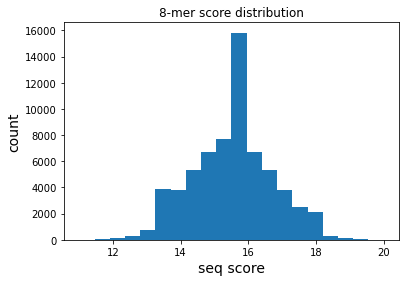

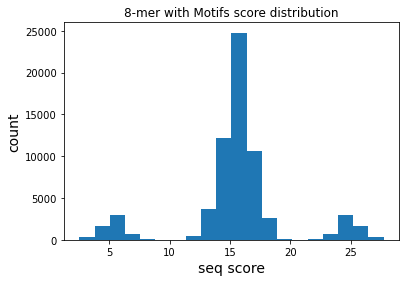

In [8]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [9]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [10]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
    
def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

# Try with 8 mers

# Single task Regression with Motifs
### Linear Model

In [11]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

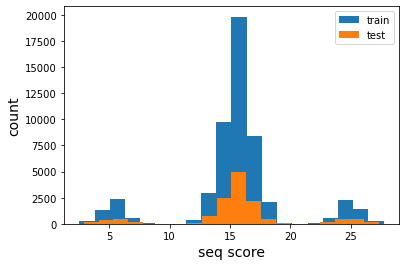

In [12]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


0 12.766510584840406
1 12.764133398175275
2 12.787411336777666
3 12.829269998187076
4 12.756633832264063
5 12.851871603703696
6 12.734243120185333
7 13.02888447731997
8 12.7813956618018
9 12.723069349185046
10 12.739995800424794
11 12.864521410503801
12 12.777952070048133
13 12.862374348750667
14 12.785116664330916
15 12.767685225925177
16 12.741794791296556
17 12.849857021349393
18 12.859327135951482
19 12.753879184025543


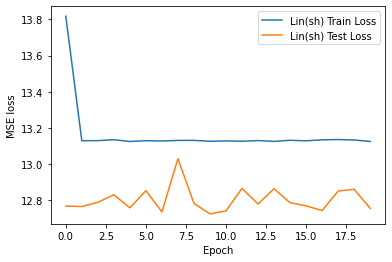

In [13]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

In [14]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_s,oracle_8mer_motif)

AAAAAAAA: pred:23.559 actual:20.000 (-3.559)
CCCCCCCC: pred:13.830 actual:17.000 (3.170)
GGGGGGGG: pred:7.484 actual:14.000 (6.516)
TTTTTTTT: pred:17.644 actual:11.000 (-6.644)

AACCAACA: pred:18.911 actual:18.875 (-0.036)
CCGGCGCG: pred:10.235 actual:5.500 (-4.735)
GGGTAAGG: pred:14.583 actual:15.125 (0.542)
TTTCGTTT: pred:14.591 actual:12.125 (-2.466)
TGTAATAC: pred:19.829 actual:15.500 (-4.329)

TATAAAAA: pred:22.464 actual:27.750 (5.286)
CCTATCCC: pred:17.114 actual:25.875 (8.761)
GTATGGGG: pred:12.500 actual:24.000 (11.500)
TTTATTTT: pred:18.064 actual:22.125 (4.061)

AAGCGAAA: pred:17.038 actual:8.125 (-8.913)
CGCGCCCC: pred:12.568 actual:6.250 (-6.318)
GGGCGGGG: pred:8.429 actual:4.375 (-4.054)
TTGCGTTT: pred:12.680 actual:2.500 (-10.180)

ATATGCGA: pred:15.873 actual:15.875 (0.002)
TGCGTATT: pred:14.593 actual:13.625 (-0.968)



0 7.285956453187531
1 3.587549833133521
2 1.9112441699621079
3 1.0565074668719179
4 0.6994017756211256
5 0.5959424783512928
6 0.5910132487060381
7 0.5736491764171762
8 0.5301271749380152
9 0.49385575429847034
10 0.4783341930133311
11 0.4997394152901053
12 0.47480019336585655
13 0.46618896165591556
14 0.4791630257842855
15 0.5631701172791879
16 0.464511936149359
17 1.1702432482411558
18 0.48595952965176487
19 0.4308747787826868


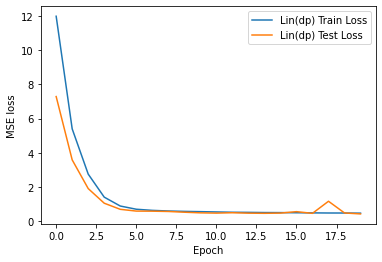

In [15]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [16]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:20.005 actual:20.000 (-0.005)
CCCCCCCC: pred:17.082 actual:17.000 (-0.082)
GGGGGGGG: pred:13.901 actual:14.000 (0.099)
TTTTTTTT: pred:11.056 actual:11.000 (-0.056)

AACCAACA: pred:18.974 actual:18.875 (-0.099)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.303 actual:15.125 (-0.178)
TTTCGTTT: pred:11.752 actual:12.125 (0.373)
TGTAATAC: pred:16.132 actual:15.500 (-0.632)

TATAAAAA: pred:25.116 actual:27.750 (2.634)
CCTATCCC: pred:26.115 actual:25.875 (-0.240)
GTATGGGG: pred:24.061 actual:24.000 (-0.061)
TTTATTTT: pred:21.059 actual:22.125 (1.066)

AAGCGAAA: pred:8.462 actual:8.125 (-0.337)
CGCGCCCC: pred:6.398 actual:6.250 (-0.148)
GGGCGGGG: pred:4.688 actual:4.375 (-0.313)
TTGCGTTT: pred:1.952 actual:2.500 (0.548)

ATATGCGA: pred:15.792 actual:15.875 (0.083)
TGCGTATT: pred:14.164 actual:13.625 (-0.539)



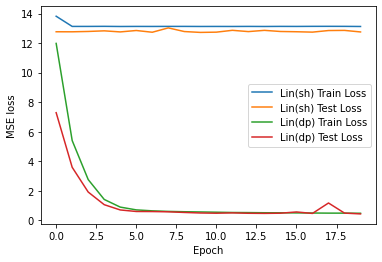

In [17]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label
)

### CNN Model

0 1.0480503943499528
1 0.16414080585273785
2 0.035274794000889544
3 0.01561280377397824
4 0.015180625142029416
5 0.01025951874551034
6 0.008122774673346813
7 0.003839201181911007
8 0.004213631772364619
9 0.005091669808896544
10 0.0022224854379781158
11 0.0019270087060430585
12 0.02541633081947262
13 0.0016854783161919787
14 0.0024680737392493704
15 0.0018468501545177067
16 0.0012832010173552757
17 0.0011181093802861836
18 0.002399250992139789
19 0.0018596592428109975


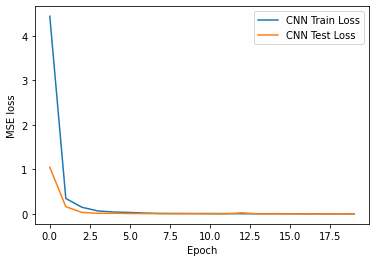

In [18]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
    lr=0.01
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [19]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.089 actual:20.000 (-0.089)
CCCCCCCC: pred:17.034 actual:17.000 (-0.034)
GGGGGGGG: pred:14.009 actual:14.000 (-0.009)
TTTTTTTT: pred:11.035 actual:11.000 (-0.035)

AACCAACA: pred:18.929 actual:18.875 (-0.054)
CCGGCGCG: pred:5.320 actual:5.500 (0.180)
GGGTAAGG: pred:15.174 actual:15.125 (-0.049)
TTTCGTTT: pred:12.154 actual:12.125 (-0.029)
TGTAATAC: pred:15.535 actual:15.500 (-0.035)

TATAAAAA: pred:27.685 actual:27.750 (0.065)
CCTATCCC: pred:25.875 actual:25.875 (0.000)
GTATGGGG: pred:24.066 actual:24.000 (-0.066)
TTTATTTT: pred:22.178 actual:22.125 (-0.053)

AAGCGAAA: pred:8.215 actual:8.125 (-0.090)
CGCGCCCC: pred:6.199 actual:6.250 (0.051)
GGGCGGGG: pred:4.406 actual:4.375 (-0.031)
TTGCGTTT: pred:2.976 actual:2.500 (-0.476)

ATATGCGA: pred:15.672 actual:15.875 (0.203)
TGCGTATT: pred:13.666 actual:13.625 (-0.041)



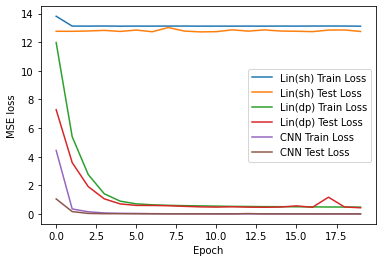

In [20]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

Running LinearShallow_8mer


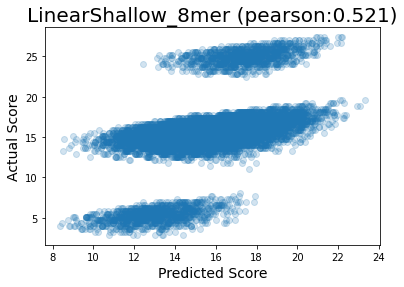

Running LinearDeep_8mer


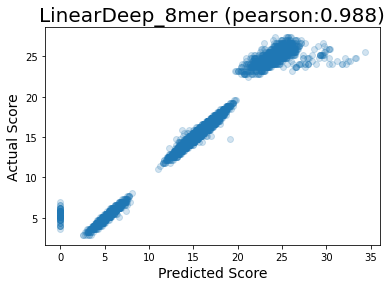

Running CNN_8mer


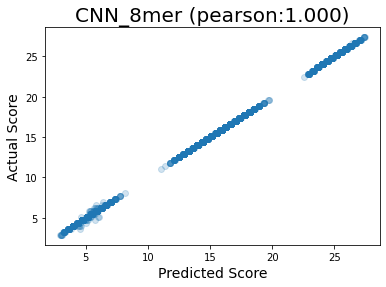

In [21]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# try to export to keras

In [22]:
mer8motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 31, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=186, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [23]:
mer8motif_model_lin_d

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=24, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)

# Try onnx export

In [24]:
# PERPETUAL DEATH
seqs = ["AAAAAAAA","TTTTTTTT","CCCCCCCC","GGGGGGGG","GGGTATGG","AAGCGAAA"]
ohe_seqs = [u.one_hot_encode(x) for x in seqs]

In [25]:
dummy_input = torch.from_numpy(ohe_seqs[0].reshape(1, -1)).float()
dummy_output = mer8motif_model_lin_d(dummy_input)
print(dummy_output)

tensor([[20.0049]], grad_fn=<ReluBackward1>)


In [26]:
torch.onnx.export(mer8motif_model_lin_d, 
                  dummy_input, 
                  'model_simple.onnx', 
                  input_names=['test_input'], 
                  output_names=['test_output'])


## Try to convert onnx output to keras

In [33]:
import keras
import onnx
import onnx2keras
from onnx2keras import onnx_to_keras

Using TensorFlow backend.


In [28]:
onnx_model = onnx.load('model_simple.onnx')
k_model = onnx_to_keras(onnx_model, ['test_input'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight lin.0.weight with shape (24, 32).
DEBUG:onnx2keras:Found weight lin.0.bias with shape (24,).
DEBUG:onnx2keras:Found weight lin.2.weight with shape (1, 24).
DEBUG:onnx2keras:Found weight lin.2.bias with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [32]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: 5
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name test_input).
DEBUG:onnx2keras:Check in

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
DEBUG:onnx2keras:Output TF Layer -> Tensor("5/BiasAdd:0", shape=(?, 24), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 6
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 5).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> Tensor("6/Relu:0", shape=(?, 24), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: 7
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 6)

In [29]:
k_model

In [30]:
for seq in seqs:
    #ohe_seq = np.array(u.one_hot_encode(seq))
    ohe_seq1 = torch.Tensor(u.one_hot_encode(seq))
    ohe_seq2 = np.array(torch.from_numpy(u.one_hot_encode(seq).reshape(1, -1)).float())
    res = mer8motif_model_lin_d(ohe_seq1)
    res2 = k_model.predict(ohe_seq2)
    print(f"{seq}:{res}, {res2}")

AAAAAAAA:tensor([20.0049], grad_fn=<ReluBackward1>), [[20.004925]]
TTTTTTTT:tensor([11.0560], grad_fn=<ReluBackward1>), [[11.055981]]
CCCCCCCC:tensor([17.0822], grad_fn=<ReluBackward1>), [[17.082218]]
GGGGGGGG:tensor([13.9010], grad_fn=<ReluBackward1>), [[13.90099]]
GGGTATGG:tensor([23.6851], grad_fn=<ReluBackward1>), [[23.68505]]
AAGCGAAA:tensor([8.4623], grad_fn=<ReluBackward1>), [[8.462255]]


In [31]:
k_model.save('practice.h5')

In [37]:
k_model_reload = keras.models.load_model("practice.h5")

In [38]:
for seq in seqs:
    #ohe_seq = np.array(u.one_hot_encode(seq))
    ohe_seq1 = torch.Tensor(u.one_hot_encode(seq))
    ohe_seq2 = np.array(torch.from_numpy(u.one_hot_encode(seq).reshape(1, -1)).float())
    res = mer8motif_model_lin_d(ohe_seq1)
    res2 = k_model.predict(ohe_seq2)
    res3 = k_model_reload.predict(ohe_seq2)
    print(f"{seq}:{res}, {res2}, {res3}")

AAAAAAAA:tensor([20.0049], grad_fn=<ReluBackward1>), [[20.004925]], [[20.004925]]
TTTTTTTT:tensor([11.0560], grad_fn=<ReluBackward1>), [[11.055981]], [[11.055981]]
CCCCCCCC:tensor([17.0822], grad_fn=<ReluBackward1>), [[17.082218]], [[17.082218]]
GGGGGGGG:tensor([13.9010], grad_fn=<ReluBackward1>), [[13.90099]], [[13.90099]]
GGGTATGG:tensor([23.6851], grad_fn=<ReluBackward1>), [[23.68505]], [[23.68505]]
AAGCGAAA:tensor([8.4623], grad_fn=<ReluBackward1>), [[8.462255]], [[8.462255]]


# inspect

# 8mer model cnn

Total convolutional layers: 1


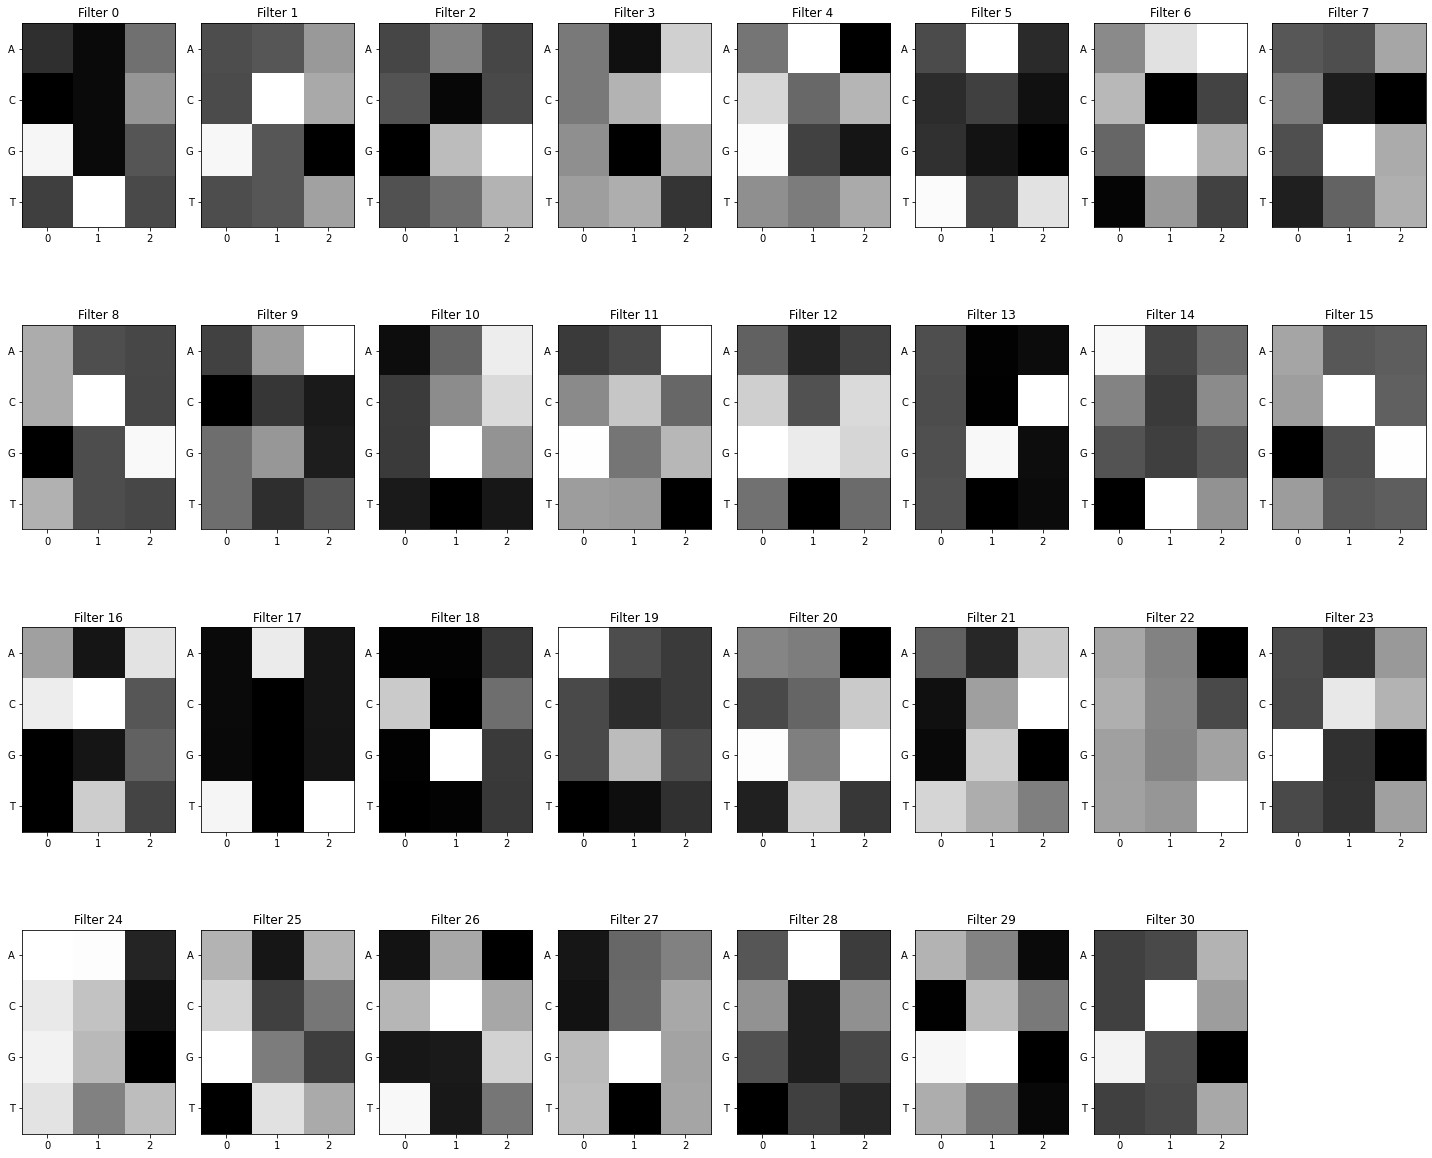

In [26]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(mer8motif_model_cnn)
u.view_filters(model_weights)

In [29]:
#train_seqs = list(mer8motif_train_df['seq'])# still using mer6 seqs is ok cuz just getting activations!
seqs8_5k = u.downselect_list(seqs8,5000)
filter_activations = u.get_filter_activations(seqs8_5k, conv_layers[0])

Running seq GGAAAGAT
Running seq ATAGACCC
Running seq CGCGTAAA
Running seq GTGGCGAA
Running seq ATCACAAT
Running seq TCGCGGGG
Running seq GCTGGGCA
Running seq TTGGTAAT
Running seq TTCGTGGT
Running seq TGTACAGA
Running seq CGCGACAG
Running seq CCCGCCCA
Running seq ATAGGCGT
Running seq CTTGTTAG
Running seq CCCCTCAT
Running seq ACCCACGG
Running seq TAAATGGC
Running seq ATGACTAA
Running seq TGTGTGTT
Running seq CATTAACC
Running seq GGTCTCGT
Running seq GATGGAAC
Running seq GCTGCCTG
Running seq ATGTAGGG
Running seq CGGCGAGA
Running seq ATATTCCC
Running seq GTCCTACT
Running seq ATGAGATT
Running seq GCCGCGGG
Running seq TGACTGAA
Running seq TTGTGACT
Running seq CAAATAGT
Running seq CCGTATAT
Running seq ACATTCAC
Running seq GTTCATGC
Running seq ACCCAAAT
Running seq AATACCCG
Running seq TAGAGACG
Running seq CTTGTGTG
Running seq AAGTACCG
Running seq ATGCCGTG
Running seq AACAGCGC
Running seq AGCGGTCC
Running seq GCCGGAGA
Running seq CCGGGGGA
Running seq TTGATGGC
Running seq ACACGCAG
Running seq G

Running seq GAAGCTGG
Running seq TGAGCACG
Running seq CCCTAGAC
Running seq AAGGGGTA
Running seq TCCTGCAT
Running seq CACGCAGT
Running seq GCGGGCTA
Running seq GTTCGGAG
Running seq GCCACGAA
Running seq AAGTTTAT
Running seq ACGGGGAT
Running seq ATTTTTGG
Running seq GCGCTGTG
Running seq CCGTGTCC
Running seq TAAGGATA
Running seq TTGCAAAT
Running seq GACCTATT
Running seq TGTTCAAG
Running seq ATGGTGAT
Running seq GTGTTAAG
Running seq GGGCGTCG
Running seq AAGAGCCT
Running seq ATAGTTCT
Running seq GGCGTGAA
Running seq ACCGTGAG
Running seq GAGCTTAA
Running seq CGCTGTCA
Running seq ATGGGCTC
Running seq CATCTATA
Running seq TTTTGGAC
Running seq CACCTCGG
Running seq AATACGCT
Running seq GACCAGAG
Running seq ACACGGTA
Running seq GGTCCTGT
Running seq ATTGTATG
Running seq TCCGCTGT
Running seq CCTCAGAG
Running seq GCTAGGGC
Running seq CCCCACAC
Running seq CGCCAGTA
Running seq ATTCGGCA
Running seq CCTCGGTT
Running seq CGCCCGAG
Running seq TTTCTGCG
Running seq ATAGGAGT
Running seq TGACTCAG
Running seq T

Running seq TCGTTGCG
Running seq GCGAAATG
Running seq GGCACTGG
Running seq ACCGTCGT
Running seq CATTTAAC
Running seq GGATGATT
Running seq GGTGGAAG
Running seq TGCATCAA
Running seq CATTAGTA
Running seq TGCGAAGA
Running seq AAGTTGCC
Running seq AGAAAGAA
Running seq AACGTATC
Running seq CGCCGGAT
Running seq GCGCGTGT
Running seq AGTATAGC
Running seq CAGAGGAT
Running seq GTAGATTA
Running seq GGCAATTC
Running seq GATCTGAA
Running seq GCTCGAAG
Running seq GTAGAGCC
Running seq ACTATAGT
Running seq ATCCTGTT
Running seq TAGACACC
Running seq ACATAAAC
Running seq GTATGGTG
Running seq CAAAAGTA
Running seq GCACAGTC
Running seq GACCGAAT
Running seq GACCACGC
Running seq GAGCCTAT
Running seq CACGCACA
Running seq GTGCGTAA
Running seq AATCCACA
Running seq TCCCGAGC
Running seq TCAGGTTA
Running seq CGTACCGA
Running seq TGGACTTT
Running seq AGGTCAGA
Running seq TGCAATCG
Running seq TCTCTGTT
Running seq TTGTCAGG
Running seq ACGCTATC
Running seq CGGCTTGT
Running seq GCAGTAGA
Running seq ACGGTCGA
Running seq C

Running seq GACTGTTG
Running seq ACTCCGGG
Running seq TGATTGAG
Running seq AACGATCG
Running seq TTGGGGCG
Running seq TTTTATAG
Running seq CCAAGGCA
Running seq CCGCCTTC
Running seq CATCTCGT
Running seq GACGACGC
Running seq CAAGGAGG
Running seq GTACTGAT
Running seq AGAACGGC
Running seq AAGGCTAG
Running seq TGGGCAAG
Running seq ACCGTGTT
Running seq TCGGGACC
Running seq GTTTCCAT
Running seq ACGGACAA
Running seq CCGCGGTT
Running seq AGACGCGC
Running seq CGTCGAAA
Running seq AGACGCTT
Running seq TATTGCTT
Running seq GCCCGATT
Running seq GGGCAAAA
Running seq TCTCCGGG
Running seq ATAAATTG
Running seq GCCCGTTC
Running seq CCGGATCA
Running seq CGTCAGAG
Running seq GATAGTAG
Running seq TGCCCTCC
Running seq ATAGAGCC
Running seq TTTGGCGC
Running seq AGTGGCGG
Running seq TCCCGAAA
Running seq ATGGCCTT
Running seq TTATGGGG
Running seq GTAGCAGT
Running seq TGAAGAGC
Running seq GTCTAAGA
Running seq GATACAGT
Running seq TGTGATTA
Running seq AGATTCCG
Running seq GATTGGCG
Running seq CGCCTAGA
Running seq A

Running seq ATGATGCA
Running seq AGGTACGA
Running seq AGGATCGT
Running seq TACGCTGA
Running seq CGAAGATA
Running seq AAGGACTC
Running seq AGACACGA
Running seq TGTATGGA
Running seq TACTCCAT
Running seq GCCTGTCA
Running seq TGCCGGAG
Running seq AACCTTTA
Running seq TGTAGGAA
Running seq ATGCCTGG
Running seq CAGTGCTC
Running seq GACTCCCC
Running seq CGACCATG
Running seq CGAGTGAA
Running seq GCGTTGAT
Running seq GGGTGGCG
Running seq CGGTCTTA
Running seq TAGGGACC
Running seq GGATTGAG
Running seq AAGGGCGG
Running seq ATCGTTAT
Running seq AGTTATTC
Running seq CCGTGTCG
Running seq GGGGTGTA
Running seq TTCAATGA
Running seq TGCACCTA
Running seq TCCACAAA
Running seq AGAGACTT
Running seq GCTATGTA
Running seq GCAGCTAT
Running seq ATGCGGGC
Running seq CCCATGTT
Running seq CAACATGT
Running seq TTAGATCT
Running seq ACACCTGG
Running seq TGCCGAAA
Running seq TTTCCAGA
Running seq GGCTGAGA
Running seq GTATGCCC
Running seq GGGAAGGT
Running seq AGACCGCA
Running seq TTCAATGT
Running seq CTCCTCCG
Running seq G

Running seq GGCATGAT
Running seq CTAATACT
Running seq GCGATTCC
Running seq CAACTTTC
Running seq TCAGACCC
Running seq GTTATGCC
Running seq TTGTTGCA
Running seq CATAGATT
Running seq CTGGTCGG
Running seq GTAGTGGA
Running seq GATGCGAT
Running seq ATTTATCC
Running seq CTTATTTC
Running seq GGAATGTG
Running seq TAATAGAC
Running seq CGGGAACC
Running seq CATCTTGT
Running seq AGCCATTA
Running seq CTAACAGT
Running seq GTACGACT
Running seq TATCTGCG
Running seq CAAACCAA
Running seq TCGGTTGG
Running seq TTTTTCAT
Running seq CGTCGCTC
Running seq CCACGGGT
Running seq TGAGGCAA
Running seq ATCATTTC
Running seq GGGGTGCT
Running seq CCATCTAA
Running seq CCCCCTGT
Running seq CATCAGGT
Running seq CAGACCCT
Running seq AAGAAAAC
Running seq CTAGGAAT
Running seq CGGGAATT
Running seq TTCTTCGC
Running seq GACGATTG
Running seq CTAACGGG
Running seq TCTGGCTC
Running seq TGCTGTAT
Running seq CCGCGCCA
Running seq ACTTTTCC
Running seq ACAAACTC
Running seq TGTATTGG
Running seq GGTCAACT
Running seq GTCTGGTT
Running seq C

Running seq GGAGACGG
Running seq TGTATTGA
Running seq CGGTTAAT
Running seq GTGTGTAG
Running seq CTCTACAC
Running seq GGTCCTGC
Running seq GCCCGCTT
Running seq AGTGGTAG
Running seq TTCGACAA
Running seq CGAGTACG
Running seq CGAAAGTG
Running seq CGGACCCT
Running seq AAGCTGCC
Running seq TGTTTCAT
Running seq ATAGCTCC
Running seq AATGAACA
Running seq CATGTCAT
Running seq AGCTCCGG
Running seq GTAGACGA
Running seq ATATATTA
Running seq TTCTTCCA
Running seq GAAGAATA
Running seq ACTGGGCT
Running seq ATCCAGCA
Running seq GTATTCAC
Running seq GCAGCATC
Running seq GGTTTGGG
Running seq TGGATGGC
Running seq TTTTGACG
Running seq CCGCATAT
Running seq AAGGGGGC
Running seq AGGCGCCG
Running seq GCATTAGC
Running seq CGTCAGGT
Running seq TTCGTGCG
Running seq ACTTTCTT
Running seq GTCAGTTG
Running seq AGGGTGTT
Running seq AGAAGGTC
Running seq CTCGATCT
Running seq TGCTGCGA
Running seq AGTGGCAT
Running seq ACACGACT
Running seq TAGATATC
Running seq CACCGATT
Running seq ATAATAAT
Running seq CTACTTTA
Running seq C

Running seq ACACTGGT
Running seq CCTTTAGT
Running seq GCTCGCGC
Running seq CAGCTTAT
Running seq TATCGATA
Running seq AACGCGTC
Running seq GCCCATAA
Running seq ATTACTGT
Running seq TTTTGCGA
Running seq CCCTCGCG
Running seq CAGTGCCC
Running seq TATGTTGC
Running seq CCAGCCGG
Running seq GTGGAGCT
Running seq CTTCCTAT
Running seq TCAAACTA
Running seq CAATTCGA
Running seq AGGCCAGC
Running seq TAAGCGGC
Running seq CTAGTCGT
Running seq GGCCCGAC
Running seq AATCTGCC
Running seq GACTCAAC
Running seq AAGCCGTT
Running seq GGATCTCC
Running seq TATGAGCG
Running seq CGCAAGTG
Running seq CATTCAAT
Running seq GAACACGA
Running seq GCGTGCAT
Running seq ACACGTTG
Running seq GGCGATAT
Running seq GCTTATAT
Running seq AGTCGCGG
Running seq TCCAATGA
Running seq GCGTCGAA
Running seq AGAGTGGA
Running seq CTTGATGA
Running seq CCAAAAGT
Running seq TGTCGATC
Running seq GCGTTGAA
Running seq AATACGCG
Running seq ATTGCCAG
Running seq GGTTGATC
Running seq TATGGCGT
Running seq ACGTGTCA
Running seq AATTCAAG
Running seq G

Running seq CTTGACGG
Running seq ACTGTGCA
Running seq CGCAGGAA
Running seq GGTAAGTA
Running seq GATCGCTA
Running seq CTTAAGAT
Running seq ATTGAACG
Running seq TAGTACAC
Running seq CATCTGTG
Running seq GTCCCATA
Running seq GAATTGCA
Running seq GAAGGTTG
Running seq GTTCTTTG
Running seq TAAGATTA
Running seq TTGGGCCG
Running seq TCGGCTTA
Running seq ATACGCTC
Running seq AGATATCA
Running seq TCAGTAGA
Running seq TGCACCAC
Running seq GCGGCGAT
Running seq GAGGAAGC
Running seq CCTGAATA
Running seq TTTATATA
Running seq AGCAACCA
Running seq AAGGGTAC
Running seq GGTGTTCA
Running seq GGACCTCT
Running seq AGGTCGTT
Running seq AAACGTCC
Running seq AGACCGAT
Running seq TCTCCTCT
Running seq ATCGTCGG
Running seq TTACAAGG
Running seq TGCCGTGT
Running seq AATGACAA
Running seq GAGTGGGA
Running seq CACCGTCG
Running seq TGAAACAG
Running seq CCTTGCGC
Running seq GCACCTGT
Running seq GAGGGTCC
Running seq GGTTGATT
Running seq CAGCGGGT
Running seq CACGACCA
Running seq TCCGAGAT
Running seq GGACTTCC
Running seq T

Running seq GGGTTGGG
Running seq ATCTTGAG
Running seq CCCACAAA
Running seq ACGGTTCA
Running seq CGGGAGCG
Running seq ATTTAATG
Running seq TGGCCATT
Running seq GGGTCTCT
Running seq CTATGCTC
Running seq CCGAGAAT
Running seq TCGACCAC
Running seq TATTGACA
Running seq TCGTATAC
Running seq CCGGCAAC
Running seq TGAATCCT
Running seq GCTGAGGC
Running seq AACAGTGC
Running seq CGTGTCTT
Running seq TTAACGCC
Running seq CTTACTAC
Running seq ATATACTT
Running seq TTAGAGCG
Running seq TGAGTGAT
Running seq CTCAGAGG
Running seq CCTGCCTA
Running seq AGGGTGTA
Running seq CATCGTCC
Running seq TATCTAAT
Running seq AAGGAGTG
Running seq GCCGTTCC
Running seq TTGGACTC
Running seq ACAATGTG
Running seq GGAATTGT
Running seq AGATTCAA
Running seq TTAATCAT
Running seq CGGAAAGG
Running seq TTCTGGCC
Running seq TCCTGTTC
Running seq GGTCTTTG
Running seq TCCAACCT
Running seq GCTGGGTT
Running seq GTACCCTG
Running seq CAGGTTGT
Running seq GTATCAAA
Running seq TAGGGTTC
Running seq GCGGAATG
Running seq ACCTTCAG
Running seq A

Running seq CAGTCGAT
Running seq ACGGATGC
Running seq TAGTTCTT
Running seq GGGGTTTA
Running seq AAAGCGTT
Running seq CCATCGTA
Running seq TATCTGTT
Running seq GGTCGTCT
Running seq AGTATTGC
Running seq TCTTAGGC
Running seq TGTGACGT
Running seq TAACAAAT
Running seq ATGAAACC
Running seq GTACTTCC
Running seq AACGTTCC
Running seq CATGGTAC
Running seq CGCTTCCT
Running seq ATTATGCG
Running seq AGATTGTG
Running seq ATCGGACG
Running seq CAACGACA
Running seq GTTAAATT
Running seq TGTAATTG
Running seq CACCGACC
Running seq AGGAAGTT
Running seq AAAAGCAA
Running seq ATAACTTC
Running seq AACGGGGC
Running seq GTGGGCGC
Running seq AACCCGTA
Running seq GAACATTG
Running seq GCGGCCGA
Running seq CGTATACC
Running seq ACCCATAT
Running seq CAGGAAGG
Running seq CTTACTGA
Running seq TGCCTACT
Running seq GCGTCAGG
Running seq ATAATACA
Running seq GAATCAGC
Running seq ATCCTAAG
Running seq TACTCAAG
Running seq TCGCATTA
Running seq CTTGGGAT
Running seq ACTCCAAA
Running seq ATGGAATT
Running seq CTATCATG
Running seq G

Running seq AAGGCCTT
Running seq CATATCTT
Running seq ATCCGGTC
Running seq AGGCCCGG
Running seq GTTTTACA
Running seq GTTACGCC
Running seq CATCATCT
Running seq AGCGCAGA
Running seq TACTATCC
Running seq CAAAGGAT
Running seq CATAGGAA
Running seq TCCTTTCA
Running seq CAACGAAG
Running seq CATCTTTG
Running seq TCCGGCTA
Running seq TTAACTTC
Running seq CCTCTGCA
Running seq TCTAGAGA
Running seq TTGCCGTG
Running seq GTGTCATG
Running seq GGAGCTAT
Running seq AATACCAT
Running seq TCAAAATT
Running seq GCGATGAC
Running seq GGGGCTCG
Running seq CTACTACC
Running seq ATCACGCA
Running seq TCTCTTAA
Running seq GACGTCTT
Running seq ATCGAAAG
Running seq TGGTGAAG
Running seq CAGGATTG
Running seq ACGCGGCC
Running seq ATTGGGAC
Running seq AAGGCCTA
Running seq CCAGCGCT
Running seq GGGCCCCG
Running seq CATGGCTT
Running seq TAACTCGT
Running seq AACAGAAC
Running seq ACGGCTGA
Running seq CGTCTCGG
Running seq CTTGAATT
Running seq AGAGGACC
Running seq AGGTGCAA
Running seq GTCGGTGA
Running seq AGTCCCGA
Running seq C

Running seq AATCGAGA
Running seq ATTATTGA
Running seq AAAGGGCT
Running seq CAAGAGGT
Running seq CCCTTGTT
Running seq AACTCGCG
Running seq ATCGTCAG
Running seq AGATGTCT
Running seq TGCATAGT
Running seq AAAGGGTG
Running seq AGCTCCTG
Running seq GGTAAGAT
Running seq GGCCAGCC
Running seq CGAAGATC
Running seq ACTTCAGG
Running seq ATTGCACT
Running seq TAAGTCAC
Running seq ACCCCGAC
Running seq ATTACTAA
Running seq TGTCGGCG
Running seq GGGGCAAT
Running seq CTATGACT
Running seq CAACGGAT
Running seq CCCCGTGA
Running seq GTCTAACC
Running seq AACTCAGC
Running seq ACGACAAA
Running seq TAAGTGTG
Running seq AAGCGCTT
Running seq ACACGAGC
Running seq TACTTGGT
Running seq AGCATGGC
Running seq CTCGACCA
Running seq CGCTGTGT
Running seq CGTGAACG
Running seq GTGCGCTA
Running seq GATACTCG
Running seq CGACGTTC
Running seq ACAGATCG
Running seq CCCCGTTA
Running seq TAGCGATA
Running seq ACCTCGCA
Running seq TTAGGAGA
Running seq TGGACCCA
Running seq CCTGGTAG
Running seq ACGGGGCA
Running seq CAGTTCCT
Running seq G

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/hom

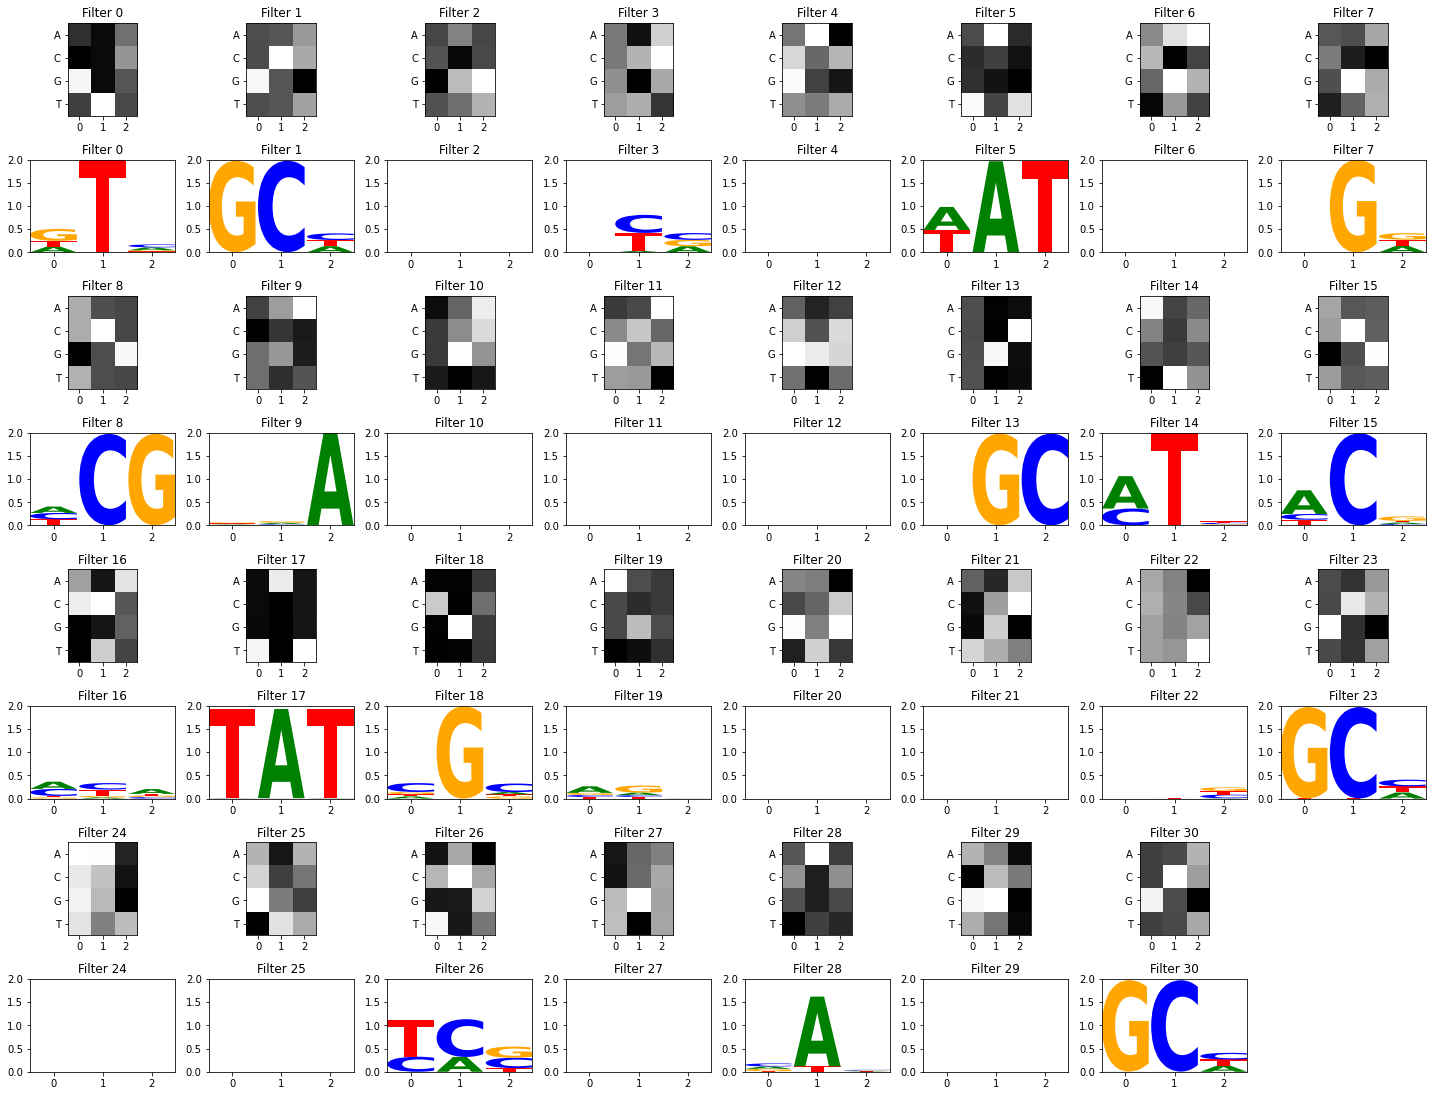

In [30]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTMs

In [46]:
# mer8motif_train_dl,\
# mer8motif_test_dl, \
# mer8motif_train_df, \
# mer8motif_test_df = u.build_dataloaders_single(mer8_motif,batch_size=11)
# change to batch size 11 so I can figure out the dimension errors

In [47]:
# class DNA_LSTM(nn.Module):
#     def __init__(self,
#                  seq_len,
#                  hidden_dim=10,
#                  layer1_dim=12,
#                  #layer2_dim=12
#                 ):
#         super().__init__()
#         self.seq_len = seq_len
#         self.hidden_dim = hidden_dim
        
#         self.hidden_init_values = None
#         self.hidden = self.init_hidden() # tuple of hidden state and cell state
        
#         self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
# #         self.fc = nn.Sequential(
# #             nn.ReLU(inplace=True),
# #             #nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         )
#         self.fc = nn.Linear(hidden_dim, 1)
            
# #         self.rnn = nn.Sequential(
# #             nn.LSTM(4, hidden_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Flatten(),
# #             nn.Linear(hidden_dim, layer1_dim),
# #             nn.ReLU(inplace=True),
# #             nn.Linear(layer1_dim, 1),
# #         ) 
    
#     def init_hidden(self):
#         if self.hidden_init_values == None:
#             self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
#                                        autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
#         return self.hidden_init_values
#         #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

#     def forward(self, xb):
#         # WRONG? reshape view to batch_ssize x 4channel x seq_len
#         # for LSTM? reshape view to seq_len x batch_ssize x 4channel  
#         # permute to put channel in correct order
#         print("original xb.shape:", xb.shape)
#         print(xb)
#         xb = xb.view(-1,self.seq_len,4)#.permute(1,0,2) 
#         print("re-viewed xb.shape:", xb.shape) # >> 11, 8, 4
#         print(xb)
#         #print(xb[0])
#         #print("xb shape", xb.shape)

#         # ** Init hidden temp **
#         batch_size = xb.shape[0]
#         print("batch_size:",batch_size)
#         (h, c) =  (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)) 
#         # *******
        
#         lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
#         print("lstm_out",lstm_out)
#         print("^^^^^lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
#         print("lstm_out[-1] shape:",lstm_out[-1].shape)
#         print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape)
#         print("hidden len:",len(self.hidden))
#         print("hidden[0] shape:", self.hidden[0].shape)
#         print("hidden[0][-1] shape:", self.hidden[0][-1].shape)
#         print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape)
        
#         print("*****")
#         A = lstm_out[-1][-1]
#         B = self.hidden[0][-1][-1]
#         print("lstm_out[-1][-1]:",A)
#         print("self.hidden[0][-1][-1]",B)
#         print("==?", A==B)
#         print("*****")
        
#         #linear_in = lstm_out.contiguous().view(-1, self.hidden_dim)
#         #print("Linear In shape:", linear_in.shape)
#         #print("self.hidden",self.hidden)
#         #print(self.hidden[1].shape)
#         #out = self.fc(linear_in)
#         out = self.fc(lstm_out)
#         #print("out",out)
#         print("LSTM->FC out shape:",out.shape)
#         return out

In [48]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [50]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm
)


0 5.482639772272397
1 0.20720879422079547
2 0.10304451005793096
3 0.061557350766912974
4 0.06122919900580413
5 0.04016574221205047
6 0.044529777883259576
7 0.029307279102393415
8 0.028446515313149873
9 0.02376602609189404
10 0.03057173010807906
11 0.019461014381394432
12 0.02092862046221547
13 0.01722342472791025
14 0.015123907362735016
15 0.017284561186201294
16 0.01562197680638658
17 0.013244265430012355
18 0.011806105203458487
19 0.011503140126913588


In [52]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.669 actual:20.000 (0.331)
CCCCCCCC: pred:17.031 actual:17.000 (-0.031)
GGGGGGGG: pred:13.976 actual:14.000 (0.024)
TTTTTTTT: pred:10.856 actual:11.000 (0.144)

AACCAACA: pred:18.904 actual:18.875 (-0.029)
CCGGCGCG: pred:5.525 actual:5.500 (-0.025)
GGGTAAGG: pred:15.201 actual:15.125 (-0.076)
TTTCGTTT: pred:12.082 actual:12.125 (0.043)
TGTAATAC: pred:15.513 actual:15.500 (-0.013)

TATAAAAA: pred:27.596 actual:27.750 (0.154)
CCTATCCC: pred:25.732 actual:25.875 (0.143)
GTATGGGG: pred:23.787 actual:24.000 (0.213)
TTTATTTT: pred:21.512 actual:22.125 (0.613)

AAGCGAAA: pred:8.075 actual:8.125 (0.050)
CGCGCCCC: pred:6.440 actual:6.250 (-0.190)
GGGCGGGG: pred:4.335 actual:4.375 (0.040)
TTGCGTTT: pred:2.910 actual:2.500 (-0.410)

ATATGCGA: pred:16.169 actual:15.875 (-0.294)
TGCGTATT: pred:14.399 actual:13.625 (-0.774)



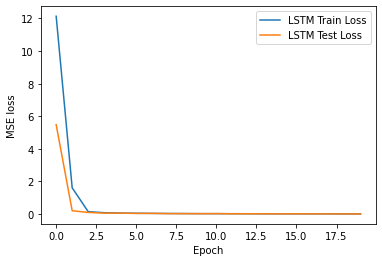

In [53]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

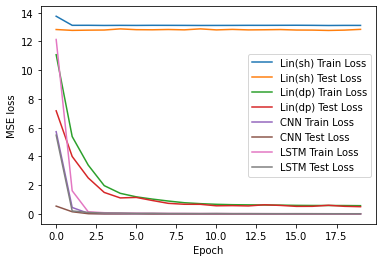

In [54]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)

# Try CNN + LSTM

In [55]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [56]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8motif_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
mer8motif_train_losses_cnnlstm,\
mer8motif_test_losses_cnnlstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnnlstm, 
)


0 0.0876547576336879
1 0.04249958451001044
2 0.02413250248075122
3 0.020523843873359846
4 0.012054300003604487
5 0.009947507342254459
6 0.009897500425468457
7 0.007924331076627428
8 0.006866361782377193
9 0.005744689862122655
10 0.005593913472983863
11 0.005798697677849976
12 0.004691510910346377
13 0.004572586285285802
14 0.004020758334145565
15 0.003920946594956729
16 0.0037218595322445398
17 0.0037923764930274948
18 0.0035863559552632342
19 0.0032435089164590566


AAAAAAAA: pred:19.817 actual:20.000 (0.183)
CCCCCCCC: pred:16.987 actual:17.000 (0.013)
GGGGGGGG: pred:13.956 actual:14.000 (0.044)
TTTTTTTT: pred:11.008 actual:11.000 (-0.008)

AACCAACA: pred:18.764 actual:18.875 (0.111)
CCGGCGCG: pred:5.604 actual:5.500 (-0.104)
GGGTAAGG: pred:15.192 actual:15.125 (-0.067)
TTTCGTTT: pred:12.193 actual:12.125 (-0.068)
TGTAATAC: pred:15.426 actual:15.500 (0.074)

TATAAAAA: pred:27.539 actual:27.750 (0.211)
CCTATCCC: pred:25.990 actual:25.875 (-0.115)
GTATGGGG: pred:23.982 actual:24.000 (0.018)
TTTATTTT: pred:22.223 actual:22.125 (-0.098)

AAGCGAAA: pred:7.950 actual:8.125 (0.175)
CGCGCCCC: pred:6.146 actual:6.250 (0.104)
GGGCGGGG: pred:4.367 actual:4.375 (0.008)
TTGCGTTT: pred:2.486 actual:2.500 (0.014)

ATATGCGA: pred:16.171 actual:15.875 (-0.296)
TGCGTATT: pred:13.178 actual:13.625 (0.447)



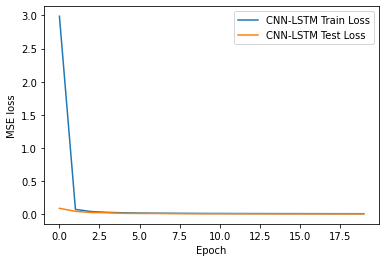

In [58]:
quick_test8(mer8motif_model_cnnlstm, oracle_8mer_motif)

mer8motif_cnnlstm_data_label = list(zip([mer8motif_train_losses_cnnlstm,mer8motif_test_losses_cnnlstm], ['CNN-LSTM Train Loss','CNN-LSTM Test Loss']))
u.quick_loss_plot(mer8motif_cnnlstm_data_label)

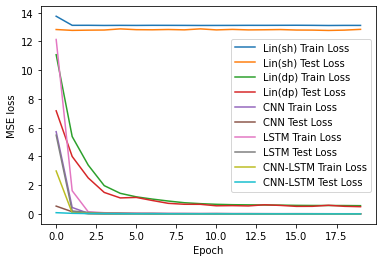

In [59]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label + \
    mer8motif_cnnlstm_data_label
)

Running LinearShallow_8mer


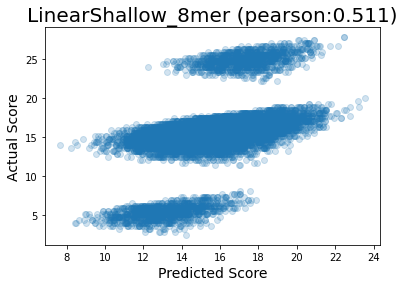

Running LinearDeep_8mer


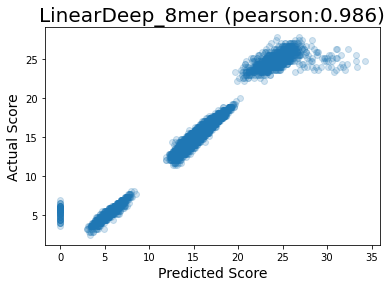

Running CNN_8mer


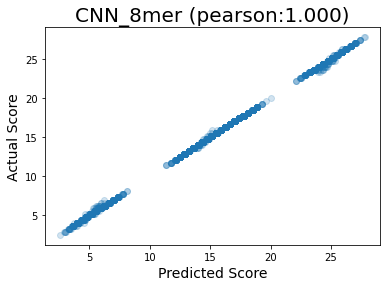

Running LSTM_8mer


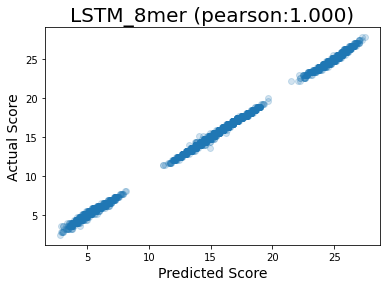

Running CNN+LSTM_8mer


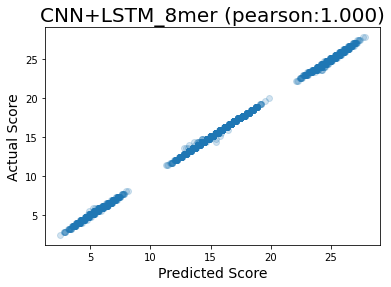

In [60]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LSTM_8mer",mer8motif_model_lstm),
    ("CNN+LSTM_8mer",mer8motif_model_cnnlstm),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)